# Convolutional Neural Networks: Step by Step

## 1 - Packages

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Configure default plot settings for consistency and readability
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # Set default plot size
plt.rcParams['image.interpolation'] = 'nearest'  # Avoid smoothing for image data
plt.rcParams['image.cmap'] = 'gray'  # Display images in grayscale by default

# Set a random seed for reproducibility
np.random.seed(1)

# Enable Jupyter-specific commands if running in a Jupyter environment
try:
    # Load the autoreload extension to automatically reload modules before executing code
    get_ipython().run_line_magic('load_ext', 'autoreload')
    # Set autoreload to reload all modules (except those imported with "from ... import ...")
    get_ipython().run_line_magic('autoreload', '2')
except NameError:
    # If not in Jupyter, skip loading these extensions
    pass


## 3 - Convolutional Neural Networks

### 3.1 - Zero-Padding

In [7]:
import numpy as np

def zero_pad(X, pad):
    """
    Pads each image in the dataset X with zeros around the height and width.

    Args:
        X (numpy.ndarray): Array of shape (m, n_H, n_W, n_C) representing a batch of m images.
        pad (int): Amount of padding to add around each image's height and width.

    Returns:
        numpy.ndarray: Padded image array of shape (m, n_H + 2*pad, n_W + 2*pad, n_C).
    """
    # Apply zero-padding around height and width dimensions
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    return X_pad


x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


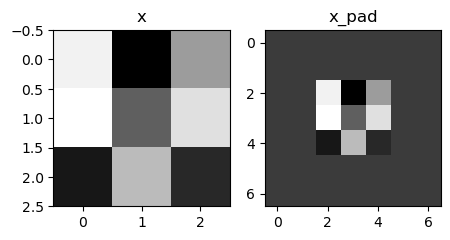

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(1)

# Generate random input data with shape (4, 3, 3, 2)
x = np.random.randn(4, 3, 3, 2)

# Apply zero padding with a pad value of 2
x_pad = zero_pad(x, 2)

# Print shapes of the original and padded arrays
print(f"x.shape = {x.shape}")
print(f"x_pad.shape = {x_pad.shape}")

# Display a specific element from both the original and padded arrays
print(f"x[1, 1] = {x[1, 1]}")
print(f"x_pad[1, 1] = {x_pad[1, 1]}")

# Visualize the first image from both original and padded arrays
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])


### 3.2 - Single step of convolution

In [10]:
import numpy as np

def conv_single_step(a_slice_prev, W, b):
    """
    Perform a single convolutional step by applying filter W and bias b on a slice of input data.
    
    Parameters:
    a_slice_prev -- 3D slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters (filter) of shape (f, f, n_C_prev)
    b -- Bias parameter, scalar or of shape (1, 1, 1)
    
    Returns:
    Z -- Scalar result of convolving the filter on the input slice
    """
    
    # Element-wise multiplication and summing up the result
    Z = np.sum(a_slice_prev * W) + b.item()  # Use .item() to extract the single value from the array
    
    return Z


In [11]:
# Set a random seed for reproducibility
np.random.seed(1)

# Generate a random 3D slice of input data and filter (weights) of the same shape
a_slice_prev = np.random.randn(4, 4, 3)  # Input data slice of shape (4, 4, 3)
W = np.random.randn(4, 4, 3)             # Filter of shape (4, 4, 3)
b = np.random.randn(1, 1, 1)             # Bias, a scalar

# Apply the convolutional single-step function to the data slice
Z = conv_single_step(a_slice_prev, W, b)

# Output the result of the convolution
print(f"Z ={Z}")


Z =-6.999089450680221


### 3.3 - Convolutional Neural Networks - Forward Pass

In [13]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Perform forward propagation for a convolutional layer.
    
    Arguments:
    A_prev -- Output activations from the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Filters, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- Dictionary containing "stride" and "pad"
        
    Returns:
    Z -- Convolution output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- Cache of values for use in backpropagation
    """
    
    # Extract dimensions
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, _, _, n_C) = W.shape
    
    # Extract hyperparameters
    stride, pad = hparameters["stride"], hparameters["pad"]
    
    # Calculate output dimensions
    n_H = (n_H_prev + 2 * pad - f) // stride + 1
    n_W = (n_W_prev + 2 * pad - f) // stride + 1
    
    # Initialize output volume Z with zeros
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Pad the input volume
    A_prev_pad = zero_pad(A_prev, pad)
    
    # Perform convolution
    for i in range(m):  # Iterate over the batch
        a_prev_pad = A_prev_pad[i]  # Padded activation for current example
        for h in range(n_H):        # Iterate over vertical axis
            vert_start, vert_end = h * stride, h * stride + f
            
            for w in range(n_W):    # Iterate over horizontal axis
                horiz_start, horiz_end = w * stride, w * stride + f
                
                for c in range(n_C):  # Iterate over channels (filters)
                    # Slice the input and apply convolution with filter W and bias b
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    weights, bias = W[..., c], b[..., c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, bias)
    
    # Ensure output shape is as expected
    assert Z.shape == (m, n_H, n_W, n_C)
    
    # Store values in cache for backward propagation
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


In [14]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(1)

# Generate random input data, weights, and biases
A_prev = np.random.randn(10, 5, 7, 4)  # Input activations (batch size: 10, height: 5, width: 7, channels: 4)
W = np.random.randn(3, 3, 4, 8)        # Filters (height: 3, width: 3, input channels: 4, output channels: 8)
b = np.random.randn(1, 1, 1, 8)        # Biases (1 for each output channel)

# Define hyperparameters for padding and stride
hparameters = {"pad": 1, "stride": 2}

# Perform the forward convolution operation
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Print summary statistics and sample values for verification
print(f"Mean of Z ={np.mean(Z)}")          # Mean of the output volume
print(f"Z[3,2,1] ={Z[3, 2, 1]}")           # Specific output element for debugging
print(f"cache_conv[0][1][2][3] ={cache_conv[0][1][2][3]}")  # Cached activation sample for backpropagation


Mean of Z =0.6923608807576933
Z[3,2,1] =[-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =[-1.1191154   1.9560789  -0.3264995  -1.34267579]


## 4 - Pooling layer

### 4.1 - Forward Pooling

In [17]:
import numpy as np

def pool_forward(A_prev, hparameters, mode="max"):
    """
    Implements the forward pass of the pooling layer.

    Parameters:
    A_prev (numpy.ndarray): Input data of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters (dict): Dictionary containing "f" (filter size) and "stride"
    mode (str): Pooling mode to apply, either "max" or "average"

    Returns:
    A (numpy.ndarray): Output of the pool layer, with shape (m, n_H, n_W, n_C)
    cache (tuple): Contains input and hparameters for use in backpropagation
    """
    
    # Retrieve dimensions and hyperparameters
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Define output dimensions
    n_H = 1 + (n_H_prev - f) // stride
    n_W = 1 + (n_W_prev - f) // stride
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    # Perform pooling operation
    for i in range(m):                         # loop over training examples
        for h in range(n_H):                   # loop over height of output
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_W):               # loop over width of output
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):           # loop over channels
                    # Select the slice for pooling
                    a_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Apply pooling operation based on mode
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice)
    
    # Cache values for backpropagation
    cache = (A_prev, hparameters)
    
    # Ensure output shape is correct
    assert A.shape == (m, n_H, n_W, n_C)
    
    return A, cache


In [18]:
#### Stride = 1

# Set up test case parameters
np.random.seed(1)  # Seed for reproducibility
A_prev = np.random.randn(2, 5, 5, 3)  # Sample input with shape (m=2, height=5, width=5, channels=3)
hparameters = {"stride": 1, "f": 3}  # Pooling parameters: stride and filter size

# Test max pooling mode
print("mode = max")
A_max, _ = pool_forward(A_prev, hparameters, mode="max")
print(f"A.shape ={A_max.shape}")  # Expected output shape
print(f"A =\n{A_max}")  # Output of max pooling

print()  # Blank line for separation

# Test average pooling mode
print("mode = average")
A_avg, _ = pool_forward(A_prev, hparameters, mode="average")
print(f"A.shape ={A_avg.shape}")  # Expected output shape
print(f"A =\n{A_avg}")  # Output of average pooling


mode = max
A.shape =(2, 3, 3, 3)
A =
[[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape =(2, 3, 3, 3)
A =
[[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [ 4.7

In [19]:
#### Stride = 2

# Set up test case parameters
np.random.seed(1)  # Seed for reproducibility
A_prev = np.random.randn(2, 5, 5, 3)  # Sample input with shape (m=2, height=5, width=5, channels=3)
hparameters = {"stride": 2, "f": 3}  # Pooling parameters: stride and filter size

# Test max pooling mode
print("mode = max")
A_max, _ = pool_forward(A_prev, hparameters, mode="max")
print(f"A.shape ={A_max.shape}")  # Expected output shape
print(f"A =\n{A_max}")  # Output of max pooling

print()  # Blank line for separation

# Test average pooling mode
print("mode = average")
A_avg, _ = pool_forward(A_prev, hparameters, mode="average")
print(f"A.shape ={A_avg.shape}")  # Expected output shape
print(f"A =\n{A_avg}")  # Output of average pooling


mode = max
A.shape =(2, 2, 2, 3)
A =
[[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape =(2, 2, 2, 3)
A =
[[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


## 5 - Backpropagation in convolutional neural network

### 5.1 - Convolutional layer backward pass

#### 5.1.1 - Computing dA

#### 5.1.2 - Computing dW

#### 5.1.3 - Computing db

In [25]:
import numpy as np

def conv_backward(dZ, cache):
    """
    Implements backward propagation for a convolutional layer.
    
    Arguments:
    dZ -- Gradient of the cost with respect to the output of the conv layer (Z),
          numpy array of shape (m, n_H, n_W, n_C)
    cache -- Cache of values from the forward pass, containing (A_prev, W, b, hparameters)
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- Gradient of the cost with respect to the weights of the conv layer (W),
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- Gradient of the cost with respect to the biases of the conv layer (b),
          numpy array of shape (1, 1, 1, n_C)
    """
    
    # Retrieve values from the cache
    A_prev, W, b, hparameters = cache
    stride, pad = hparameters["stride"], hparameters["pad"]
    
    # Retrieve dimensions
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize gradients with zeros
    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.zeros_like(b)
    
    # Pad A_prev and dA_prev
    A_prev_pad = np.pad(A_prev, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    dA_prev_pad = np.pad(dA_prev, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    
    # Loop over each training example
    for i in range(m):
        a_prev_pad = A_prev_pad[i]  # ith example of padded A_prev
        da_prev_pad = dA_prev_pad[i]  # ith example of padded dA_prev
        
        # Loop over output dimensions
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    # Define slice corners
                    vert_start, vert_end = h * stride, h * stride + f
                    horiz_start, horiz_end = w * stride, w * stride + f
                    
                    # Define slice and compute gradients
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
        
        # Unpad the gradient to get dA_prev for the ith example
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # Check output shape
    assert dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev)
    
    return dA_prev, dW, db


In [26]:
# Initialize inputs and parameters for conv_forward
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)  # Example input with shape (m, height, width, channels)
W = np.random.randn(2, 2, 3, 8)        # Weights with shape (filter_height, filter_width, input_channels, output_channels)
b = np.random.randn(1, 1, 1, 8)        # Biases for each output channel
hparameters = {"pad": 2, "stride": 2}  # Padding and stride hyperparameters

# Run forward pass to obtain Z and cache
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test backward pass with the obtained cache
dA, dW, db = conv_backward(Z, cache_conv)

# Output the means of gradients for quick verification
print(f"dA_mean = {np.mean(dA)}")
print(f"dW_mean = {np.mean(dW)}")
print(f"db_mean = {np.mean(db)}")


dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


### 5.2 - Pooling layer - backward pass

#### 5.2.1 - Max pooling - backward pass

In [29]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix `x` to identify the maximum entry in `x`.
    
    Arguments:
    x -- 2D NumPy array of shape (f, f)
    
    Returns:
    mask -- Boolean array of the same shape as `x`, containing True at the position of the maximum entry in `x`, False elsewhere.
    """
    
    # Create a mask with True at the max value's position in `x` and False elsewhere
    mask = (x == np.max(x))
    
    return mask


In [30]:
# Seed the random number generator for reproducibility
np.random.seed(1)

# Generate a 2x3 matrix of random values from a normal distribution
x = np.random.randn(2, 3)

# Apply the create_mask_from_window function to get a mask for the max entry in `x`
mask = create_mask_from_window(x)

# Display the matrix `x` and the generated mask
print(f'x =\n{x}')
print(f"mask =\n{mask}")

x =
[[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =
[[ True False False]
 [False False False]]


#### 5.2.2 - Average pooling - backward pass

In [32]:
def distribute_value(dz, shape):
    """
    Distributes a scalar value across a matrix of a specified shape.
    
    Arguments:
    dz -- Scalar to be distributed across the output matrix.
    shape -- Tuple (n_H, n_W) representing the dimensions of the output matrix.
    
    Returns:
    a -- Array of shape (n_H, n_W) where each element is the distributed value of dz.
    """
    
    # Unpack dimensions from the provided shape
    n_H, n_W = shape
    
    # Calculate the distributed value by dividing dz across all elements in the matrix
    average = dz / (n_H * n_W)
    
    # Create a matrix filled with the calculated average value
    a = np.full((n_H, n_W), average)
    
    return a


In [33]:
# Example usage
a = distribute_value(2, (2, 2))
print(f'Distributed value =\n{a}')


Distributed value =
[[0.5 0.5]
 [0.5 0.5]]


#### 5.2.3 Pulling it together: Pooling backward

In [35]:
import numpy as np

def pool_backward(dA, cache, mode="max"):
    """
    Implements the backward pass for a pooling layer.
    
    Arguments:
    dA -- Gradient of the cost with respect to the output of the pooling layer, same shape as the output (A)
    cache -- Cache output from the forward pass of the pooling layer, containing the input and hyperparameters
    mode -- Pooling mode ("max" or "average")
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the input of the pooling layer, same shape as the input (A_prev)
    """
    
    # Unpack cache values
    A_prev, hparameters = cache
    stride, f = hparameters["stride"], hparameters["f"]
    
    # Retrieve dimensions from dA and A_prev
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    _, n_H, n_W, n_C = dA.shape
    
    # Initialize the gradient for the input of the pooling layer
    dA_prev = np.zeros_like(A_prev)
    
    for i in range(m):  # Iterate over training examples
        a_prev = A_prev[i]
        
        for h in range(n_H):  # Iterate over the output height
            for w in range(n_W):  # Iterate over the output width
                for c in range(n_C):  # Iterate over channels
                    
                    # Define corners of the slice
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Slice the region of interest in the input
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                    
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
    
    # Ensure the shape matches the input
    assert dA_prev.shape == A_prev.shape
    
    return dA_prev


In [36]:
# Set random seed for reproducibility
np.random.seed(1)

# Initialize input data and hyperparameters for pooling
A_prev = np.random.randn(5, 5, 3, 2)  # Input matrix with shape (5, 5, 3, 2)
hparameters = {"stride": 1, "f": 2}  # Pooling hyperparameters

# Perform forward pooling operation
A, cache = pool_forward(A_prev, hparameters)

# Generate a random gradient matrix with the same shape as A for testing backpropagation
dA = np.random.randn(5, 4, 2, 2)

# Backpropagation for max pooling
dA_prev = pool_backward(dA, cache, mode="max")
print("mode = max")
print("Mean of dA:", np.mean(dA))
print("dA_prev[1,1]:", dA_prev[1,1])  
print()  # Blank line for separation in output

# Backpropagation for average pooling
dA_prev = pool_backward(dA, cache, mode="average")
print("mode = average")
print("Mean of dA:", np.mean(dA))
print("dA_prev[1,1]:", dA_prev[1,1])


mode = max
Mean of dA: 0.14571390272918056
dA_prev[1,1]: [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
Mean of dA: 0.14571390272918056
dA_prev[1,1]: [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
